
<img src="https://lies.mat.uc.cl/wp-content/uploads/2017/09/logo-uc-lineal-azul.png" width="200px" alt="puc logo">
<hr>
<h2 align="center"> A Bayesian Approach to select machine learning models in astronomy  </h2>
<hr>

# Experiment 1: Cross-Validation can be easily deceived   

The first hypothesis that we present is associated to indentify some practical situations in astronomy that could be generate biased datasets. (Explain sitiations when it could occur)

In specific, we try to perturbe the dataset in order to decrease the classition performance. 4

The main idea is based on hidding  important information to the classifier. Different ideas could be considered for that, for example it could be possible reduce the support for each feature and hidding the observation that having an extreme value (over a threshold) for each feature. It is also posible to hide observations more representative for the classes, these observation are very close to the learnt pattern by the classifier. 

In this experiment, we consider the second option, the especific produce is presente to continue. 

    - Fit a classifier with the complete dataset. 
    - Predict using this model (soft classification) over the complete dataset. 
    - Define $\alpha$ (threshold the filter)
    - Test set: select observations with probability over (1-$\alpha$) or bellow $\alpha$. 
    - Train set: select observations with probability bellow (1-$\alpha$) and over $\alpha$. 

In [1]:
%matplotlib inline
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import RandomForestClassifier
import  sklearn.linear_model as linearModel
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.manifold import TSNE
import numpy as np
import seaborn 
import matplotlib.pyplot as plt
from warnings import filterwarnings
filterwarnings('ignore')
import timeit
import pymc3 as pm
import matplotlib.lines as mlines
from sklearn import svm
np.random.seed(1)
from itertools import product

C:\Users\frper\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Couldn't import dot_parser, loading of dot files will not be possible.


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
import bridgeSampling as bs  # it contains a method to estimate the marginal likelihood according to the Bridge Sampling approach
import utilFunctions as ut   # it has different methods to handle and plot data 
import BayesianModels as bm  # it has methods to build and train bayesian model (Logistic Regression and Neural Nets) 
import experiments as exp  

In [3]:
# OGLE, GAIA, VVV, WISE '
#Data, ID, Class_col, Classes = ut.Initialize(survey='MACHO', sepColumns_=' ', sepHeader_= ' ')
Data, ID, Class_col, Classes = ut.Initialize(survey='VVV')

Running VVV
The dataset contains: 10000 samples


In [4]:
Classes

array(['VVV_v3_NC', 'VVV_v3_RRc', 'VVV_v3_C', 'VVV_v3_RRab', 'VVV_v3_ELL',
       'VVV_v3_OSARG'], dtype=object)

In [5]:
Class1 = Classes[3]
Class2 = Classes[2]
print('Class 1: ', Class1, ', obs: ', Data[Data[Class_col]==Class1].count()[0])
print('Class 2: ', Class2, ', obs: ', Data[Data[Class_col]==Class2].count()[0])

Class 1:  VVV_v3_RRab , obs:  868
Class 2:  VVV_v3_C , obs:  1502


### DropEasy_ =  False

LPV v/s EB, when are dropped the harder instances the accuracy difference between the training and testing sets is over 0.5. If we drop the easier instances the distance is reduced, but it continues being over 0.2.
 

In [6]:
results_summary, model_ogle, trace, dataTrain, dataTest = exp.runExperiments(Data,  class_1= Class1, class_2=Class2, components= [2],
                                                                                                 method=[7], size=[0.8], ml= True, 
                                                                                                 fit_iterations= 20000, name_class_col_= Class_col, 
                                                                                                 id_col_=ID, biasedSplit = True, 
                                                                                                 ModifiedPrior = False, DropEasy_ =  False, 
                                                                                                 alpha_ = 0.75,  oneToOne_ = True, kernel=False)


Running Define TrainSet
(10000, 62)
(10000, 62)
One To One
(2370, 62)
(2370, 60)
(2370, 2)
Acc: 0.8556962025316456
Drop Difficult obs=True
Alpha:  0.75
Shape training:  (926, 61)
Shape testing:  (1444, 61)
Running experiments
(926, 61)
(1444, 61)
2
Index(['Class', 'PC0', 'PC1'], dtype='object')


WARNING (theano.gof.compilelock): Overriding existing lock by dead process '16320' (I am process '12196')


------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 20500/20500 [01:10<00:00, 289.31it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


2
20000
10000
20000
20000
The Bridge Sampling Estimatation of Logml is -175.80336
return the last model and trace


In [ ]:
obs_fold = 5

In [22]:

labelTrain = dataTrain['label']
labelTest = dataTest['label']
del dataTrain['label']
del dataTest['label']

### Complete dataset

In [23]:
clf = linearModel.LogisticRegression(C=1.0)
clf.fit(dataTrain, labelTrain)
prediction_freq = clf.predict(dataTrain)
print('Accuracy train:' , accuracy_score(labelTrain, prediction_freq, normalize=True))

prediction_freq = clf.predict(dataTest)
print('Accuracy test:' , accuracy_score(labelTest, prediction_freq, normalize=True))

Accuracy train: 0.947882736156
Accuracy test: 0.355263157895


### Leave one out

In [24]:
loo = LeaveOneOut()
loo.get_n_splits(dataTrain)
LeaveOneOut()
clf = linearModel.LogisticRegression(C=1.0)
acc = []
for train_index, test_index in loo.split(dataTrain):
    X_train, X_test = dataTrain.iloc[train_index,:], dataTrain.iloc[test_index,:]
    y_train, y_test = labelTrain.iloc[train_index], labelTrain.iloc[test_index]
    clf.fit(X_train, y_train)
    prediction_freq = clf.predict(X_test)
    acc.append(accuracy_score(y_test, prediction_freq, normalize=True))

In [25]:
'{}'.format(np.mean(acc))

'0.9478827361563518'

### K-Fold

In [26]:
n_split_train = dataTrain.shape[0]/obs_fold
n_split_test = dataTest.shape[0]/ obs_fold
print('Number of folds in train', int(n_split_train))
print('Number of folds in test',int(n_split_test))

Number of folds in train 61
Number of folds in test 15


### Logistic Regression

Training...
Testing...


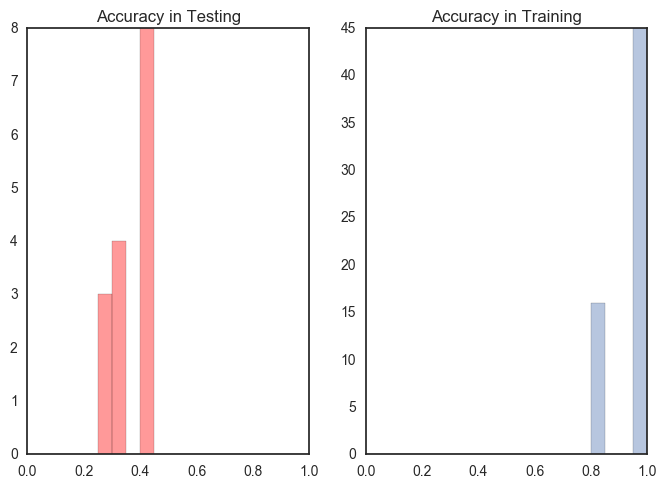

In [27]:
n_split_train = dataTrain.shape[0]/obs_fold
n_split_test = dataTest.shape[0]/ obs_fold
clf1 = linearModel.LogisticRegression(C=1.0)
acc_kfold, acc_kfold_Test = ut.KFold(dataTrain, labelTrain, dataTest, labelTest, n_split_test, n_split_train, clf1)
ut.comparativePlotAcc(acc_kfold_Test, acc_kfold)

### Support Vector Machine

Training...
Testing...


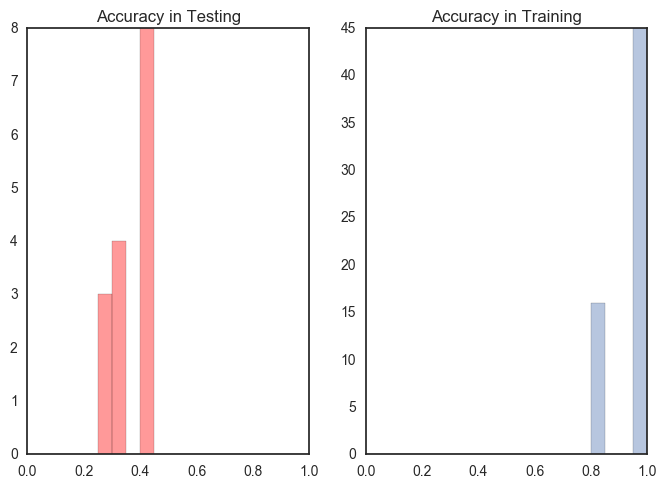

In [28]:
clf2 = svm.SVC(C=1.0)
acc_kfold, acc_kfold_Test = ut.KFold(dataTrain, labelTrain, dataTest, labelTest, n_split_test, n_split_train, clf2)
ut.comparativePlotAcc(acc_kfold_Test, acc_kfold)

Training...
Testing...


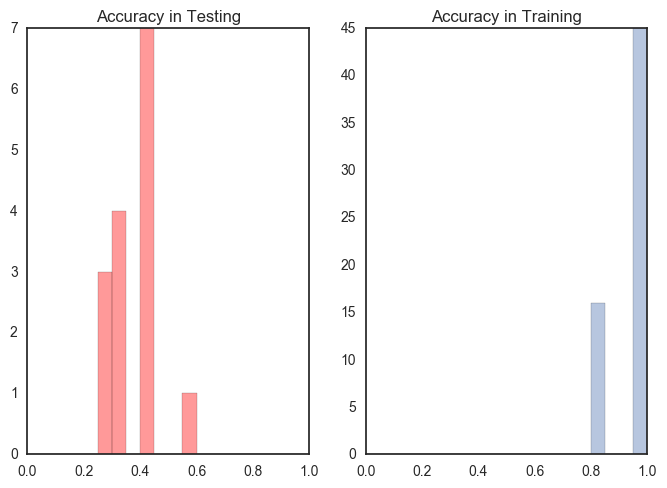

In [29]:
clf3 = RandomForestClassifier(max_depth=2, random_state=0)
acc_kfold, acc_kfold_Test = ut.KFold(dataTrain, labelTrain, dataTest, labelTest, n_split_test, n_split_train, clf3)
ut.comparativePlotAcc(acc_kfold_Test, acc_kfold)


# DropEasy_ =  True

In [83]:
results_summary, model_ogle, trace, dataTrain, dataTest = exp.runExperiments(Data,  class_1= Class1, class_2=Class2, components= [8],
                                                                                                 method=[7], size=[0.8], ml= True, 
                                                                                                 fit_iterations= 20000, name_class_col_= Class_col, 
                                                                                                 id_col_=ID, biasedSplit = True, 
                                                                                                 ModifiedPrior = False, DropEasy_ =  True, 
                                                                                                 alpha_ = 0.75,  oneToOne_ = True)


Running Define TrainSet
(10000, 62)
(10000, 62)
One To One
(434, 62)
(434, 60)
(434, 2)
Acc: 0.937788018433
Drop Easy obs=True
Alpha:  0.75
Shape training:  (40, 61)
Shape testing:  (394, 61)
Running experiments
(40, 61)
(394, 61)
8
------- Metropolis--------


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [PC7]
>Metropolis: [PC6]
>Metropolis: [PC5]
>Metropolis: [PC4]
>Metropolis: [PC3]
>Metropolis: [PC2]
>Metropolis: [PC1]
>Metropolis: [PC0]
>Metropolis: [Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 20500/20500 [00:49<00:00, 417.68it/s]
The number of effective samples is smaller than 10% for some parameters.


2
20000
10000
20000
20000
The Bridge Sampling Estimatation of Logml is -45.23514
return the last model and trace


In [88]:
obs_fold = 5
labelTrain = dataTrain['label']
labelTest = dataTest['label']
del dataTrain['label']
del dataTest['label']

In [89]:
clf = linearModel.LogisticRegression(C=1.0)
clf.fit(dataTrain, labelTrain)
prediction_freq = clf.predict(dataTrain)
print('Accuracy train:' , accuracy_score(labelTrain, prediction_freq, normalize=True))

prediction_freq = clf.predict(dataTest)
print('Accuracy test:' , accuracy_score(labelTest, prediction_freq, normalize=True))

Accuracy train: 0.775
Accuracy test: 0.0812182741117


### Logistic Regression

Training...
Testing...


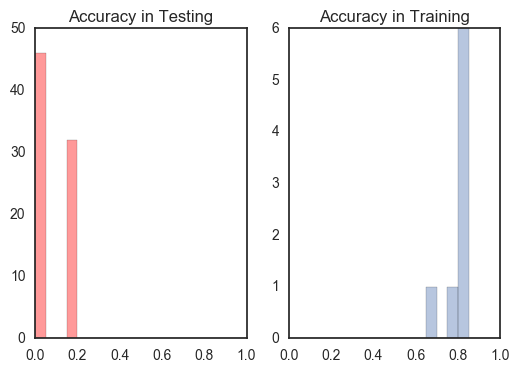

In [90]:
n_split_train = dataTrain.shape[0]/obs_fold
n_split_test = dataTest.shape[0]/ obs_fold
clf1 = linearModel.LogisticRegression(C=1.0)
acc_kfold, acc_kfold_Test = ut.KFold(dataTrain, labelTrain, dataTest, labelTest, n_split_test, n_split_train, clf1)
ut.comparativePlotAcc(acc_kfold_Test, acc_kfold)

### Support Vector Machine

Training...
Testing...


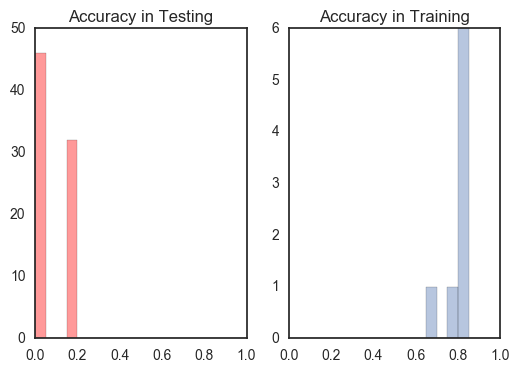

In [91]:
clf2 = svm.SVC(C=1.0)
acc_kfold, acc_kfold_Test = ut.KFold(dataTrain, labelTrain, dataTest, labelTest, n_split_test, n_split_train, clf2)
ut.comparativePlotAcc(acc_kfold_Test, acc_kfold)

### Random Forest

Training...
Testing...


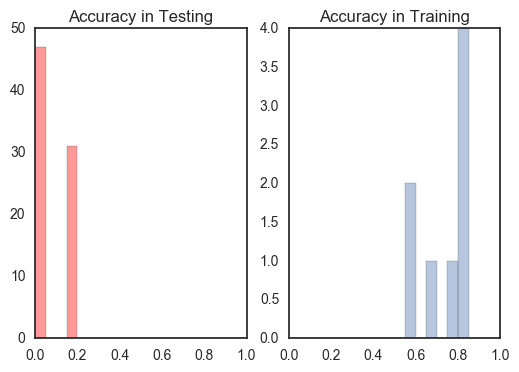

In [92]:
clf3 = RandomForestClassifier(max_depth=2, random_state=0)
acc_kfold, acc_kfold_Test = ut.KFold(dataTrain, labelTrain, dataTest, labelTest, n_split_test, n_split_train, clf3)
ut.comparativePlotAcc(acc_kfold_Test, acc_kfold)